# Multivariate Regression

We will first use seaborn to fit a linear regression model that predicts `Distance` from `AirTime`. Next, we will split the data set into a training set and a test. Then, we will use the training set to fit a multivariate regression model that predicts `Distance` from `AirTime` and `ArrDelay`. Finally, we will evaulate the performance of our model on the test set.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import statsmodels.api as sm
import statsmodels.formula.api as smf
from helper import *

sns.set(style="white", font_scale=2.0)
filename = '~/2001.csv'

In [2]:
usecols = (13, 14, 16, 18)
columns = ['AirTime', 'ArrDelay', 'Origin', 'Distance']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)
set_data(all_data)

## Seaborn Regression

`plot_seaborn_reg()` creates a scatter plot with `AirTime` in the $x$-axis and `Distance` in the $y$-axis. It also fita a linear regression model in the same plot. Note that the function returns an instance of *matplotlib Axes* object.

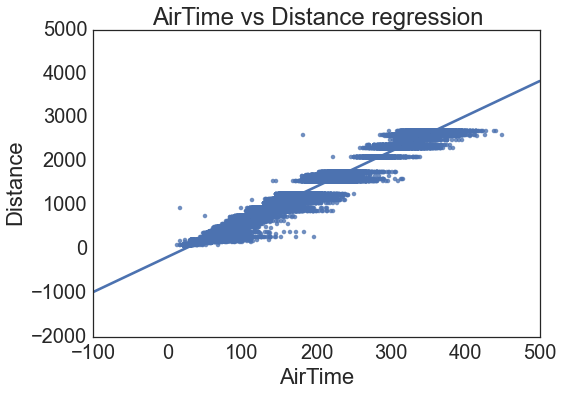

In [3]:
change_origin("BOS")
plot_seaborn_reg('AirTime','Distance')

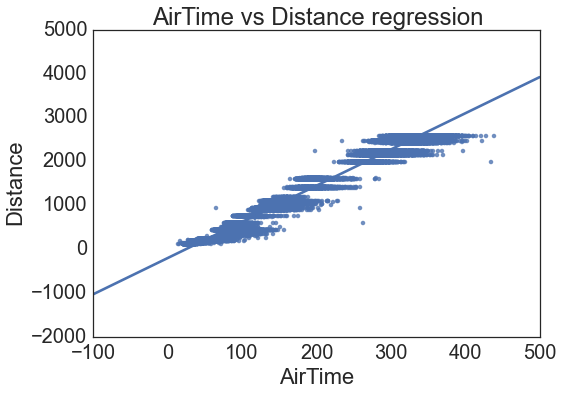

In [4]:
change_origin("JFK")
plot_seaborn_reg('AirTime','Distance')

## Train-Test Split

We will split our data set into a training set and a testing set. We will use only the training set to train a multivariate regresion model, use it to predict `Distance` in the test set, and compare the predictions with the true values in the test set.

In [5]:
change_origin("LAX")

X_train, X_test, y_train, y_test = get_train_test(
    train_columns=['AirTime', 'ArrDelay'],
    test_columns=['Distance'],
    test_size=0.2,
    random_state=check_random_state(0)
)

We will now include `ArrDelay` in the regression model in addition to `AirTime`. In other words, we now have two independent variables `AirTime` and `ArrDelay`, and the dependent variable is `Distance`.

`get_statsmodels_reg()` uses a patsy formula (from R) in the statsmodels package on the `AirTime`, `ArrDelay`, and `Distance` variables.

In [6]:
X_pred, y_pred = get_statsmodels_reg(X_train,X_test,y_train)

Finally, we plot the model we trained with `get_statsmodels_reg()`. Note that the plot_statsmodels_reg() returns a *matplotlib Axes* object.

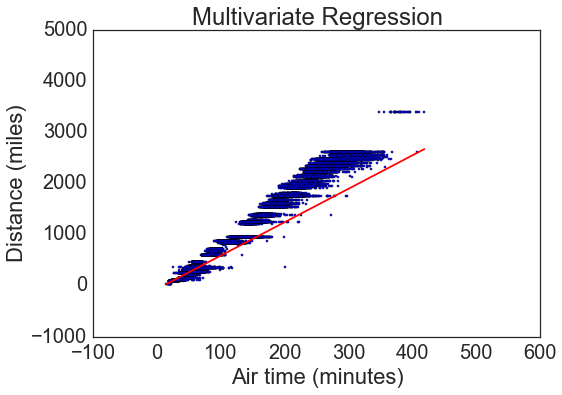

In [7]:
plot_statsmodels_reg(X_test, X_pred, y_test, y_pred)

# Regularization

We will use a Ridge Regression model to fit a polynomial that estimates departure delays from the scheduled departure time.

In [8]:
usecols = (5, 15, 16)
columns = ['CRSDepTime', 'DepDelay', 'Origin']

new_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)
set_data(new_data)
change_origin("ORD")
set_hourly()

`plot_seaborn_reg()` creates a scatter plot with `CRSDepTime` in the $x$-axis and `DepDelay` in the $y$-axis. A linear regression model will also be fit in the same plot. The function should return an instance of *matplotlib Axes* object.

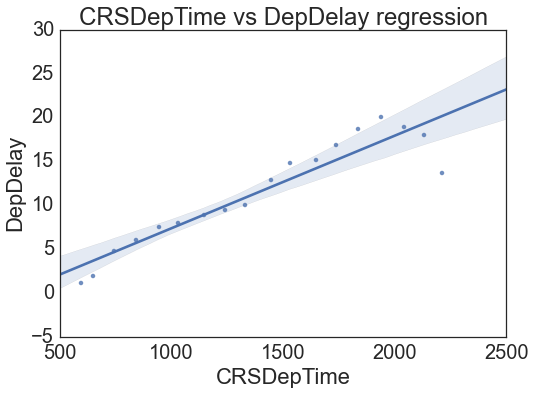

In [9]:
plot_seaborn_reg('CRSDepTime','DepDelay')

A linear regression model doesn't fit the points that well. Instead, we should probably fit a polynomial model. We will first discover what degree polynomial will work best.

In [10]:
degrees = list()
for i in range(1, 15):
    degrees.append(find_mse(i))

best_degree = np.argmin(degrees) + 1 # because degree = 1 corresponds to arg = 0
print('The best model is a polynomial of degree {}.'.format(best_degree))

The best model is a polynomial of degree 11.


`fit_reg_poly()` fits a ridge regression model. The function returns a tuple cotaining a *sklearn.Pipeline* object and the model predictions, as a *numpy ndarray*. `plot_reg_poly` will plot the trained model, including a scatter plot between the `DepDelay` and `DepTime`.

We notice that the ridge model fits the data very well. That is because we have plotted the data used to train the model. It is likely that we are overfitting. A better approach would be to split the data into training and testing sets and plotting and evaluating the model on unseen data.

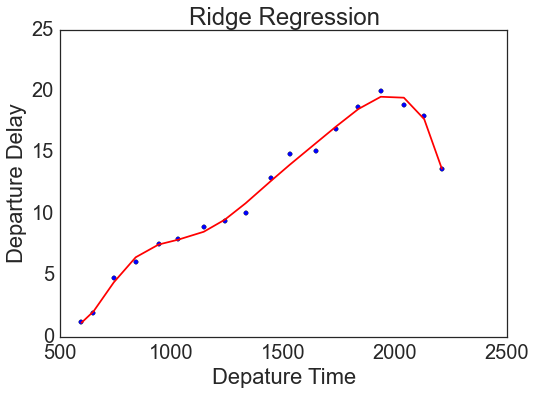

In [11]:
model, prediction = fit_reg_poly(best_degree)
plot_reg_poly(model, prediction)

# Logistic Regression

We will fit a logistic regression model on day of the week and air carriers to predict whether a flight is delayed or not. We will use the columns `DayOfWeek` and `UniqueCarrier` as attributes and `DepDelay` as the target prediction.

In [12]:
usecols = (3, 8, 15, 17)
columns = ['DayOfWeek', 'UniqueCarrier', 'DepDelay', 'Origin']

final_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns).dropna()

set_data(final_data)
change_origin("ORD")

Our logit model will predict a binary response. `convert_to_binary()` converts a specific column of a DataFrame into 0's or 1's using some cutoff parameter. We will also need to create dummy indicators for features with more than 2 levels. `add_dummy()` accomplishes this. Finally, `add_intercept()` is required because the **Logit** function from `statsmodels` does not include an intercept by default.

In [13]:
convert_to_binary('DepDelay', 5)
add_dummy(add_columns=['DayOfWeek', 'UniqueCarrier'], keep_columns=['DepDelay_binary'])
add_intercept()

# We choose these columns based upon the airport we selected above (ORD) 
# The columns (especially UniqueCarrier) would differ dependent on another airport
# depending on the result of add_dummy()

train_columns = [
    'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
    'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
    'UniqueCarrier_AS', 'UniqueCarrier_CO', 'UniqueCarrier_DL',
    'UniqueCarrier_HP', 'UniqueCarrier_MQ', 'UniqueCarrier_NW',
    'UniqueCarrier_TW', 'UniqueCarrier_UA', 'UniqueCarrier_US',
    'Intercept'
]

`fit_logistic()` uses `Logit()` to fit a logistic regression model to the columns in `train_columns`. It uses non-regularized maximum likelihood with all default parameters.

In [14]:
model, result = fit_logitistic(train_columns=train_columns, test_column='DepDelay_binary')

Optimization terminated successfully.
         Current function value: 0.589094
         Iterations 5


In [15]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:        DepDelay_binary   No. Observations:               321227
Model:                          Logit   Df Residuals:                   321211
Method:                           MLE   Df Model:                           15
Date:                Fri, 20 May 2016   Pseudo R-squ.:                0.005735
Time:                        16:22:01   Log-Likelihood:            -1.8923e+05
converged:                       True   LL-Null:                   -1.9032e+05
                                        LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
DayOfWeek_2         -0.1574      0.015    -10.479      0.000        -0.187    -0.128
DayOfWeek_3          0.0164      0.015      1.113      0.266        -0.012     0.045
DayOfWeek_4          0.2148 

In [16]:
local = get_original_data()

We can calculate the mean of `DepDelay` for each day of the week. We see that Thursday and Friday have the highest mean values.

In [17]:
print(local.groupby('DayOfWeek').mean().sort_values(by='DepDelay', ascending=False))

            DepDelay
DayOfWeek           
5          11.008359
4           9.207526
7           8.827786
6           7.774358
1           7.223767
3           6.931689
2           6.083388


We can do the same for UniqueCarrier, to see that HP and DL airlines indeed have the highest mean departure delay.

In [18]:
print(local.groupby('UniqueCarrier').mean().sort_values(by='DepDelay', ascending=False))

               DayOfWeek   DepDelay
UniqueCarrier                      
UA              3.967892  11.036894
AS              3.946123  10.971319
MQ              3.940478  10.448874
HP              3.959926   9.858910
AA              3.964992   9.026836
WN              3.907511   8.761087
DL              3.995136   7.500546
TW              3.953250   6.013395
US              3.963997   5.881445
NW              3.938718   5.799110
CO              3.877533   5.541169
AQ              4.039381   4.199717
